<a href="https://colab.research.google.com/github/Harsha080996/ML-assignments/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem 1: Feature extraction with data augmentation**

In [1]:
#images for cats and dogs from google
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 15:58:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  62.0MB/s    in 1.1s    

2019-04-17 15:58:31 (62.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
from keras.applications import VGG19 #Downloading VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step


In [5]:
conv_base.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Freezing the convulutional base**

In [0]:
conv_base.trainable = False  

In [9]:
#Extracting features from last layer in VGG19
for layer in conv_base.layers:
  layer.trainable = False
  
last_layer = conv_base.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


**Concatenate the convolutional base and densely connected layers**

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras import Model


x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = models.Model(conv_base.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Train the model end to end with frozen convolutional base**

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 40s 397ms/step - loss: 0.5790 - acc: 0.6890 - val_loss: 0.4374 - val_acc: 0.7930
Epoch 2/30
100/100 [==============================] - 32s 324ms/step - loss: 0.4823 - acc: 0.7740 - val_loss: 0.3352 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 34s 336ms/step - loss: 0.4106 - acc: 0.8040 - val_loss: 0.3012 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 33s 326ms/step - loss: 0.3892 - acc: 0.8270 - val_loss: 0.2872 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 34s 340ms/step - loss: 0.3717 - acc: 0.8365 - val_loss: 0.2541 - val_acc: 0.8990
Epoch 6/30
100/100 [==============================] - 33s 327ms/step - loss: 0.3553 - acc: 0.8395 - val_loss: 0.2889 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 34s 

**Display curves of loss and accuracy during training**

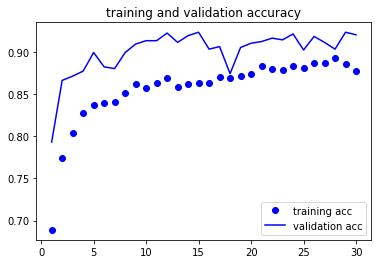

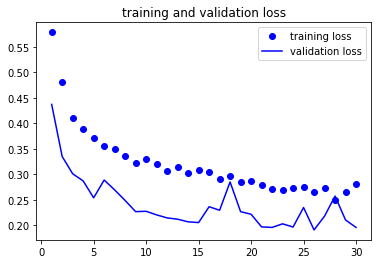

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Problem 2: Fine tuning with data augmentation**

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

**Training with smaller learning rate**

In [15]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/50
100/100 [==============================] - 36s 363ms/step - loss: 0.2779 - acc: 0.8840 - val_loss: 0.1629 - val_acc: 0.9300
Epoch 2/50
100/100 [==============================] - 34s 339ms/step - loss: 0.2078 - acc: 0.9140 - val_loss: 0.1446 - val_acc: 0.9390
Epoch 3/50
100/100 [==============================] - 34s 343ms/step - loss: 0.2003 - acc: 0.9170 - val_loss: 0.1431 - val_acc: 0.9450
Epoch 4/50
100/100 [==============================] - 33s 333ms/step - loss: 0.1786 - acc: 0.9240 - val_loss: 0.1097 - val_acc: 0.9650
Epoch 5/50
100/100 [==============================] - 33s 331ms/step - loss: 0.1733 - acc: 0.9340 - val_loss: 0.1468 - val_acc: 0.9390
Epoch 6/50
100/100 [==============================] - 32s 324ms/step - loss: 0.1394 - acc: 0.9475 - val_loss: 0.1280 - val_acc: 0.9520
Epoch 7/50
100/100 [==============================] - 34s 339ms/step - loss: 0.1266 - acc: 0.9475 - val_loss: 0.1606 - val_acc: 0.9400
Epoch 8/50
100/100 [==============================] - 3

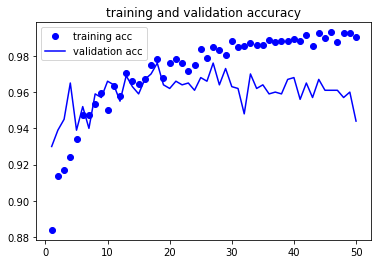

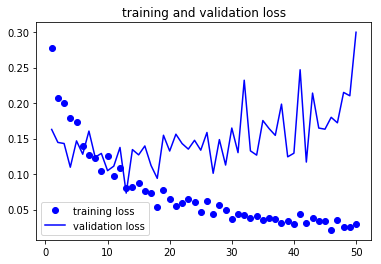

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: [0.280052949488163, 0.2623970056883991, 0.188663087785244, 0.2760199823603034, 0.20222021237015725, 0.4246069499850273, 0.17925276787951588, 0.27070756698027254, 0.17015855507925154, 0.17580389739014207, 0.14119857864454388, 0.26275565443560484, 0.24657889747060835, 0.20384431605692954, 0.14854507090058178, 0.2344605913385749, 0.18509444305556827, 0.1822352900239639, 0.17128043372649698, 0.21167945233173668, 0.2320498254755512, 0.22241638423409313, 0.16047973915236072, 0.1706724752811715, 0.26654612260870636, 0.17820973621448502, 0.4027697864244692, 0.16741864281793822, 0.2588481782976305, 0.19577831997768955, 0.20193016435485334, 0.31204566307947973, 0.23960487115196882, 0.20514988098566392, 0.24920308716595174, 0.23835649235639722, 0.2469785211549606, 0.30123078904329303, 0.231108023669658, 0.3716223797299608, 0.2101743267314123, 0.20087905975116882, 0.21676657291362061, 0.19976241794065572, 0.2159064024881809, 0.28956208545554546, 0.1968471826700261, 0.2454486027886

**Problem 3:  Visualizing Heat Maps of class activation for model obtained from problem 2**

In [0]:
last_conv_layer = model.get_layer('block5_conv4')

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import utils

In [0]:
def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

In [0]:

def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = model.predict(x)
 
  grads = K.gradients(model.output[:, 0], last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  show_superimposed_image(img_path, heatmap)

In [0]:
!ls /tmp/cats_and_dogs_filtered/validation/cats | head -10
!ls /tmp/cats_and_dogs_filtered/validation/dogs | head -10

In [0]:
process_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.1001.jpg')


In [0]:
process_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.1001.jpg')


**Problem 4: **